In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import json

pd.options.display.max_rows = 100

In [2]:
dfs = pd.read_html('https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States')
states = [s.replace('[E]', '').replace(' ', '-').lower() for s in list(
    dfs[0]['Flag, name andpostal abbreviation[12]']['Flag, name andpostal abbreviation[12]']
)]
', '.join(states)

'alabama, alaska, arizona, arkansas, california, colorado, connecticut, delaware, florida, georgia, hawaii, idaho, illinois, indiana, iowa, kansas, kentucky, louisiana, maine, maryland, massachusetts, michigan, minnesota, mississippi, missouri, montana, nebraska, nevada, new-hampshire, new-jersey, new-mexico, new-york, north-carolina, north-dakota, ohio, oklahoma, oregon, pennsylvania, rhode-island, south-carolina, south-dakota, tennessee, texas, utah, vermont, virginia, washington, west-virginia, wisconsin, wyoming'

In [3]:
# from https://worldpopulationreview.com/state-rankings/blue-states
# and  https://worldpopulationreview.com/state-rankings/red-states
blue = '''California
Connecticut
Delaware
Hawaii
Illinois
Maryland
Massachusetts
Minnesota
New Jersey
New Mexico
New York
Oregon
Rhode Island
Vermont
Washington'''

red = '''Alabama
Alaska
Idaho
Kansas
Montana
Nebraska
North Dakota
Oklahoma
South Carolina
South Dakota
Tennessee
Utah
Wyoming'''

swing_states = list(set(['pennsylvania', 'michigan', 'wisconsin', 'arizona', 'florida', 'north-carolina', 'nevada']))
blue_states = list(set([b.replace(' ', '-').lower() for b in blue.split('\n')]))
red_states = list(set([r.replace(' ', '-').lower() for r in red.split('\n')]))

print(f'BLUE STATES: {blue_states}')
print(f'RED STATES: {red_states}')
print(f'SWING STATES: {swing_states}')

BLUE STATES: ['california', 'vermont', 'massachusetts', 'new-jersey', 'connecticut', 'delaware', 'illinois', 'oregon', 'washington', 'hawaii', 'new-mexico', 'rhode-island', 'maryland', 'minnesota', 'new-york']
RED STATES: ['wyoming', 'alabama', 'oklahoma', 'nebraska', 'kansas', 'north-dakota', 'tennessee', 'utah', 'montana', 'south-dakota', 'idaho', 'alaska', 'south-carolina']
SWING STATES: ['michigan', 'pennsylvania', 'wisconsin', 'arizona', 'north-carolina', 'florida', 'nevada']


In [4]:
g_cache = {}

def load_webpage(url, df_index):
    if url not in g_cache.keys():
        page = pd.read_html(url)
        g_cache[url] = page
    return g_cache[url][df_index]
    
def load_state(state):
    print(f'loading data for state {state}')
    df = load_webpage(f'https://www.nytimes.com/interactive/2020/11/03/us/elections/results-{state}.html', 1)
    df = pd.DataFrame(df.iloc[:-1]) # last row is 'view results'
    df['Total votes'] = df['Total votes'].astype(int)
    df['State'] = state
    return df.sort_values('Total votes', ascending = False)

def load_2016_state(state):
    print(f'loading 2016 data for state {state}')
    df = load_webpage(f'https://www.nytimes.com/elections/2016/results/{state}', 1)
    election_2016 = pd.DataFrame(df.iloc[:-1]).rename(columns={'Vote by county':'County'}) # last one is NaN
    election_2016['State'] = state
    # election_2016['TotalVotes2016'] = election_2016['Trump'] + election_2016['Clinton']
    return election_2016

In [5]:
def load_from_cache_or_web(pkl_name, loading_func):
    try:
        us_df = pd.read_pickle(pkl_name)
    except:
        result = {}
        for s in states:
            s = s.lower()
            result[s] = loading_func(s)

        us_df = pd.concat(result.values())
        us_df.to_pickle(pkl_name)
    finally:
        print(f'{pkl_name} Total: {len(us_df)}')
        display(us_df.head())
        return us_df

us_df = load_from_cache_or_web('./2020_election_data.pickle', load_state)
us_2016_df = load_from_cache_or_web('./2016_election_data.pickle', load_2016_state)

./2020_election_data.pickle Total: 4623


,County,Margin,2016 margin,Est. votes reported,Est. votes reported.1,Total votes,Absentee,State,District,Town,Parish
4,Jefferson,Biden +13,D+7.3,>98%,NaN,324675,—,alabama,NaN,NaN,NaN
5,Madison,Trump +8,R+16.3,>98%,NaN,193955,—,alabama,NaN,NaN,NaN
0,Mobile,Trump +12,R+13.3,93%,NaN,181783,—,alabama,NaN,NaN,NaN
6,Shelby,Trump +41,R+49.4,>98%,NaN,114439,—,alabama,NaN,NaN,NaN
7,Baldwin,Trump +54,R+57.2,>98%,NaN,108945,—,alabama,NaN,NaN,NaN


./2016_election_data.pickle Total: 4590


,County,Trump,Clinton,State,Candidate,Candidate.1,Party,Votes,Pct.,Unnamed: 5,Vote by town
0,Jefferson,134768.0,156873.0,alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Mobile,95116.0,72186.0,alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Madison,89520.0,62822.0,alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Shelby,73020.0,22977.0,alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Montgomery,34003.0,58916.0,alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# assuming other parties are very minimal and won't affect the votes estimation
us_df['2020_Who'] = np.where(us_df['Margin'].str.split('+', expand=True)[0].str.strip() == 'Biden','D','R')
us_df['2020_Margin'] = pd.to_numeric(us_df['Margin'].str.split('+', expand=True)[1])
us_df['2016_Who'] = us_df['2016 margin'].str.split('+', expand=True)[0].str.strip()
us_df['2016_Margin'] = pd.to_numeric(us_df['2016 margin'].str.split('+', expand=True)[1])
us_df.head()

,County,Margin,2016 margin,Est. votes reported,Est. votes reported.1,Total votes,Absentee,State,District,Town,Parish,2020_Who,2020_Margin,2016_Who,2016_Margin
4,Jefferson,Biden +13,D+7.3,>98%,NaN,324675,—,alabama,NaN,NaN,NaN,D,13.0,D,7.3
5,Madison,Trump +8,R+16.3,>98%,NaN,193955,—,alabama,NaN,NaN,NaN,R,8.0,R,16.3
0,Mobile,Trump +12,R+13.3,93%,NaN,181783,—,alabama,NaN,NaN,NaN,R,12.0,R,13.3
6,Shelby,Trump +41,R+49.4,>98%,NaN,114439,—,alabama,NaN,NaN,NaN,R,41.0,R,49.4
7,Baldwin,Trump +54,R+57.2,>98%,NaN,108945,—,alabama,NaN,NaN,NaN,R,54.0,R,57.2


In [7]:
us_df[us_df['2016_Who'].isnull()].State.unique()

array(['alaska', 'connecticut', 'maine', 'massachusetts', 'new-hampshire',
       'rhode-island', 'vermont'], dtype=object)

# Shifting to a different party

In [8]:
vote_count_threshold = 10000
has_2016_data = us_df[~us_df['2016_Who'].isnull()]
shifted = has_2016_data.loc[lambda x: x['2020_Who'] != x['2016_Who']].loc[lambda x: x['Total votes'] > vote_count_threshold]
#display(shifted)
print("% of the county shifted to a different party : " + str(len(shifted) / len(has_2016_data)))

def print_q(df):
    print('Margin Percentile: ')
    print((df['2020_Margin'] + df['2016_Margin']).quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

to_d = shifted.loc[lambda x: x['2020_Who'] == 'D']
to_r = shifted.loc[lambda x: x['2020_Who'] == 'R']

def against_df(msg, df):
    print('------')
    print(msg)
    print('------')
    print(f'len : {len(df)}')
    print_q(df)
    print(f'States: {df.State.unique()}')
    
print(f'From R to D: {len(to_d)}, From D to R: {len(to_r)}')

against_df('From R to D', to_d)
against_df('From D to R', to_r)

print('States that only move to D:')
display(set(to_d.State.unique()) - set(to_r.State.unique()))
print('States that only move to R:')
display(set(to_r.State.unique()) - set(to_d.State.unique()))

% of the county shifted to a different party : 0.020374630299046993
From R to D: 46, From D to R: 16
------
From R to D
------
len : 46
Margin Percentile: 
0.25     4.625
0.50     6.045
0.75     9.325
0.90    11.400
0.95    11.725
0.99    14.915
dtype: float64
States: ['arizona' 'california' 'colorado' 'florida' 'illinois' 'indiana' 'kansas'
 'maryland' 'michigan' 'minnesota' 'mississippi' 'new-jersey'
 'north-carolina' 'ohio' 'oregon' 'pennsylvania' 'texas' 'virginia'
 'washington' 'wisconsin' 'wyoming']
------
From D to R
------
len : 16
Margin Percentile: 
0.25     3.040
0.50     6.050
0.75     9.975
0.90    17.550
0.95    18.500
0.99    19.940
dtype: float64
States: ['georgia' 'illinois' 'mississippi' 'new-york' 'north-carolina' 'ohio'
 'south-carolina' 'texas']
States that only move to D:


{'arizona',
 'california',
 'colorado',
 'florida',
 'indiana',
 'kansas',
 'maryland',
 'michigan',
 'minnesota',
 'new-jersey',
 'oregon',
 'pennsylvania',
 'virginia',
 'washington',
 'wisconsin',
 'wyoming'}

States that only move to R:


{'georgia', 'new-york', 'south-carolina'}

# Margin correlation between 2020 and 2016

In [9]:
has_2016_data[['2020_Margin', '2016_Margin']].corr()

,2020_Margin,2016_Margin
2020_Margin,1.000000,0.969693
2016_Margin,0.969693,1.000000


In [10]:
# ignore small counties
has_2016_data.loc[lambda x: x['Total votes'] > 5000].corr()

,Total votes,2020_Margin,2016_Margin
Total votes,1.000000,-0.173026,-0.167425
2020_Margin,-0.173026,1.000000,0.965963
2016_Margin,-0.167425,0.965963,1.000000


# Benford's Law

In [11]:
# use margin to estimate the vote count, this isn't accurate as other parties 
# also has a margin of the total votes, but shouldn't be a big ammount
ben_df = pd.DataFrame(us_df[['State', 'Total votes', '2020_Who', '2020_Margin', 'County']]\
                      .loc[lambda x: ~x['2020_Margin'].isnull()])
ben_df['BidenVotes'] = np.where(
    ben_df['2020_Who'] == 'D',
    ben_df['Total votes'] * ((100 + ben_df['2020_Margin']) / 200),
    ben_df['Total votes'] * ((100 - ben_df['2020_Margin']) / 200)
).astype(int)
ben_df['TrumpVotes'] = ben_df['Total votes'] - ben_df['BidenVotes']
ben_df['BidenVotesLeadingDig'] = ben_df['BidenVotes'].astype(str).str[0]
ben_df['TrumpVotesLeadingDig'] = ben_df['TrumpVotes'].astype(str).str[0]
display(ben_df.head())

,State,Total votes,2020_Who,2020_Margin,County,BidenVotes,TrumpVotes,BidenVotesLeadingDig,TrumpVotesLeadingDig
4,alabama,324675,D,13.0,Jefferson,183441,141234,1,1
5,alabama,193955,R,8.0,Madison,89219,104736,8,1
0,alabama,181783,R,12.0,Mobile,79984,101799,7,1
6,alabama,114439,R,41.0,Shelby,33759,80680,3,8
7,alabama,108945,R,54.0,Baldwin,25057,83888,2,8


In [12]:
dfs = pd.read_html('https://en.wikipedia.org/wiki/Benford%27s_law')
exp_ben = dfs[4]["In Benford's law"]["In Benford's law"].str.replace('%','').astype(float) / 100
exp_ben.index = exp_ben.index + 1
exp_ben

1    0.301
2    0.176
3    0.125
4    0.097
5    0.079
6    0.067
7    0.058
8    0.051
9    0.046
Name: In Benford's law, dtype: float64

In [13]:
final_ben_df = pd.DataFrame({
    'LeadingDigit' : range(1, 10),
    
    'BenExp': list(exp_ben),
    
    'Biden' :  ben_df.groupby('BidenVotesLeadingDig').BidenVotesLeadingDig.count() / len(ben_df),
    
    # YES, there exists one county in NH with total 5 votes that all going to Biden :-)
    'Trump' :  ben_df.loc[ben_df['TrumpVotesLeadingDig'] != '0']\
        .groupby('TrumpVotesLeadingDig').BidenVotesLeadingDig.count() / len(ben_df),
})
final_ben_df.index = final_ben_df['LeadingDigit']
del final_ben_df['LeadingDigit']
final_ben_df

,BenExp,Biden,Trump
LeadingDigit,,,
1,0.301,0.287091,0.286867
2,0.176,0.183550,0.169431
3,0.125,0.124832,0.122815
4,0.097,0.110040,0.105558
5,0.079,0.070148,0.087853
6,0.067,0.067683,0.067683
7,0.058,0.058046,0.055805
8,0.051,0.045944,0.058270
9,0.046,0.052667,0.045495


<AxesSubplot:title={'center':'Benfords Law For Expectation/Biden/Trump'}, xlabel='LeadingDigit'>

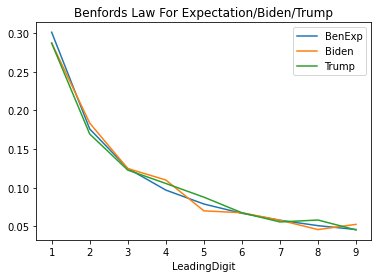

In [14]:
final_ben_df.plot(title='Benfords Law For Expectation/Biden/Trump')

# The delta in the swing states

1. Look at 2016 Trump v.s. Clinton data, calculate the R %
2. Look at 2020 Trump v.s. Biden data, calculate the R %
3. Look at the growth (2020 votes - 2016 votes), `ideally` the growth for the R % shall be close to 1. Otherwise, this could mean 
    - the younger people(?) are more leaning towards the D 
    - mailing ballots are more from young people, as this is probably more accessible and convenient. 
    - fraud votes from D, across all counties ???

In [15]:
def delta_analysis_for_state(state, _ax):
    # print(f'====== {state} ======')
    
    election_2016 = pd.DataFrame(us_2016_df.loc[lambda x: x.State == state])
    election_2016['TotalVotes2016'] = election_2016['Trump'] + election_2016['Clinton']

    election_2020 = ben_df.loc[lambda x: x.State == state][
        ['2020_Who', 'Total votes','County', 'BidenVotes', 'TrumpVotes']]\
        .rename(columns={'Total votes' : 'TotalVotes2020'})

    #print('2016 PA data: ')
    #display(election_2016.head())
    #print('2020 PA data: ')
    #display(election_2020.head())

    compare_df = election_2020.merge(election_2016, left_on='County', right_on='County')
    compare_df['Delta'] = compare_df['TotalVotes2020'] - compare_df['TotalVotes2016']
    compare_df['Delta_D'] = compare_df['BidenVotes'] - compare_df['Clinton']
    compare_df['Delta_R'] = compare_df['TrumpVotes'] - compare_df['Trump']
    compare_df['2016 R %'] = compare_df['Trump'] / (compare_df['Clinton'] + compare_df['Trump'])
    compare_df['2020 R %'] = compare_df['TrumpVotes'] / (compare_df['BidenVotes'] + compare_df['TrumpVotes'])
    compare_df['2020 Delta R %'] = compare_df['Delta_R'] / (compare_df['Delta_D'] + compare_df['Delta_R'])
    compare_df = compare_df.sort_values('TotalVotes2020', ascending = False)

    cols = ['County', 'TotalVotes2020']
    cols.extend(
        list(filter(lambda x: "R %" in x, compare_df.columns))
    )
    #display(compare_df[cols].head(1))
    compare_df['Diff'] = compare_df['2020 Delta R %'] - compare_df['2016 R %']
    compare_df = compare_df.sort_values(by='Diff')
    _ax.bar(height = compare_df['Diff'], x = compare_df['County'])
    _ax.set_title(f'{state}')

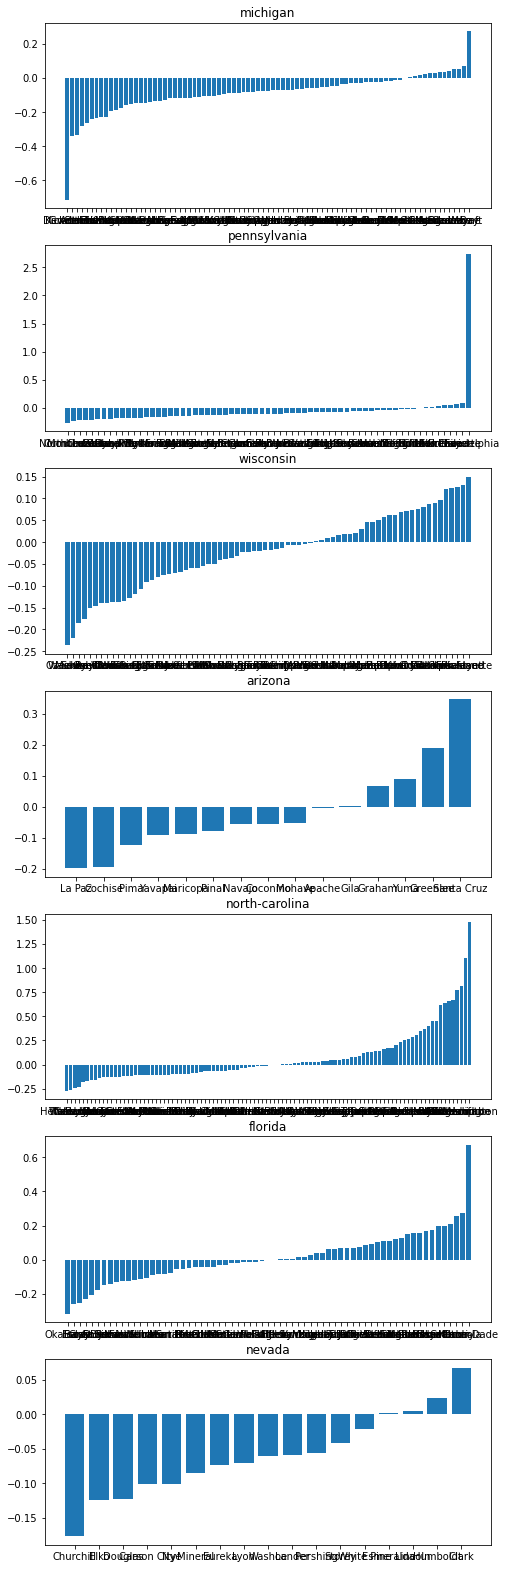

In [16]:
# Height represents the delta of the R % in the new voters v.s. 2016 voters
# The more closer to 0, more stable it is
num = len(swing_states)
fig, axs = plt.subplots(num, 1,  figsize=(8, num * 4))

i = 0
for s in swing_states:
    delta_analysis_for_state(s, axs[i])
    i += 1

# Senate votes V.S. Presidental Votes

In [17]:
def get_senate_vs_presidental(state):
    try:
        print(f'Loading {state}')
        president = load_webpage(f'https://www.nytimes.com/interactive/2020/11/03/us/elections/results-{state}.html', 0)
        senate = load_webpage(f'https://www.nytimes.com/interactive/2020/11/03/us/elections/results-{state}.html', 3)
        senate_total = senate.loc[lambda x: x['Candidate.1'] == 'Total reported Total reported']['Votes']
        #display(senate)
        president_total = president.loc[lambda x: x['Candidate.1'] == 'Total reported Total reported']['Votes']
        # display(president)
        return {
            'State' : state,
            'Senate' : senate_total.values[0],
            'President' : president_total.values[0]
        }
    except:
        # some states doesn't have senate data
        return {
            'State' : state,
            'Senate' : -1,
            'President' : -1
        }

results = [get_senate_vs_presidental(s) for s in states]

Loading alabama
Loading alaska
Loading arizona
Loading arkansas
Loading california
Loading colorado
Loading connecticut
Loading delaware
Loading florida
Loading georgia
Loading hawaii
Loading idaho
Loading illinois
Loading indiana
Loading iowa
Loading kansas
Loading kentucky
Loading louisiana
Loading maine
Loading maryland
Loading massachusetts
Loading michigan
Loading minnesota
Loading mississippi
Loading missouri
Loading montana
Loading nebraska
Loading nevada
Loading new-hampshire
Loading new-jersey
Loading new-mexico
Loading new-york
Loading north-carolina
Loading north-dakota
Loading ohio
Loading oklahoma
Loading oregon
Loading pennsylvania
Loading rhode-island
Loading south-carolina
Loading south-dakota
Loading tennessee
Loading texas
Loading utah
Loading vermont
Loading virginia
Loading washington
Loading west-virginia
Loading wisconsin
Loading wyoming


In [18]:
s_vs_p = pd.DataFrame.from_dict(results).loc[lambda x: x.Senate != -1]
s_vs_p['President'] = s_vs_p['President'].astype(int)
s_vs_p['Senate'] = s_vs_p['Senate'].astype(int)
s_vs_p['(P - S) / S'] = (s_vs_p['President'] - s_vs_p['Senate']) / s_vs_p['Senate']

def _f(kw, states):
    x = s_vs_p.loc[lambda x: x.State.isin(states)]
    mean = x['(P - S) / S'].mean()
    print(f'{kw} States: (P-S)/S Avg: {mean}')
    display(x)

_f('Swing', swing_states)
_f('Blue', blue_states)
_f('Red', red_states)

# conclusion: no evidence showing that Blue States only vote for the president, not senate

Swing States: (P-S)/S Avg: 0.009843121422780148


,State,Senate,President,(P - S) / S
2,arizona,3336172,3366867,0.009201
21,michigan,5462906,5531329,0.012525
32,north-carolina,5432052,5474442,0.007804


Blue States: (P-S)/S Avg: 0.01896304581839479


,State,Senate,President,(P - S) / S
7,delaware,490935,504010,0.026633
12,illinois,5698137,5766283,0.011959
20,massachusetts,3343516,3482216,0.041483
22,minnesota,3214950,3272469,0.017891
29,new-jersey,3934476,4033007,0.025043
30,new-mexico,914619,921308,0.007313
36,oregon,2296395,2349283,0.023031
44,vermont,362628,367432,0.013248
46,washington,3988383,4004599,0.004066


Red States: (P-S)/S Avg: 0.01809305974400425


,State,Senate,President,(P - S) / S
0,alabama,2303212,2309900,0.002904
1,alaska,260193,260983,0.003036
11,idaho,858780,867971,0.010702
15,kansas,1330054,1334330,0.003215
25,montana,602736,602781,0.000075
26,nebraska,893061,942480,0.055337
33,north-dakota,339980,361656,0.063757
35,oklahoma,1556361,1560699,0.002787
39,south-carolina,2512810,2513329,0.000207
40,south-dakota,420219,422609,0.005688


# State-level timeline data

In [19]:
state = 'georgia'.lower()

with open(f'./nytime/{state}.json') as f:
    j = json.loads(f.read())

df = pd.DataFrame.from_records(j['data']['races'][0]['timeseries'])

df = df.sort_values(by='timestamp')#.loc[lambda x: x.index % 5 == 1]

display(
    df
)

df['trumpd_share'] = [d['trumpd'] for d in df['vote_shares']]
df['bidenj_share'] = [d['bidenj'] for d in df['vote_shares']]
df['trumpd'] = (df['trumpd_share'] * df['votes']).astype(int)
df['bidenj'] = (df['bidenj_share'] * df['votes']).astype(int)
del df['vote_shares']
df['Delta_votes'] = df['votes'].diff()
df['Delta_Biden'] = df['bidenj'].diff()
df['Delta_Trump'] = df['trumpd'].diff()
df['Delta_Biden %'] = df['Delta_Biden'] / df['Delta_votes']
df['Delta_Trump %'] = df['Delta_Trump'] / df['Delta_votes']
df['Ratio'] = df['Delta_Biden %'] / df['Delta_Trump %']
# df = df.iloc[1:]
# df = df[df['Delta_votes'] > 10000]
df

,vote_shares,votes,eevp,eevp_source,timestamp
1,"{'trumpd': 0.674, 'bidenj': 0.326}",408,0,edison,2020-11-04T00:14:11Z
2,"{'bidenj': 0.618, 'trumpd': 0.37}",127106,2,edison,2020-11-04T00:15:51Z
3,"{'bidenj': 0.557, 'trumpd': 0.431}",173638,3,edison,2020-11-04T00:19:55Z
4,"{'bidenj': 0.557, 'trumpd': 0.432}",174006,3,edison,2020-11-04T00:21:57Z
5,"{'bidenj': 0.556, 'trumpd': 0.433}",174448,3,edison,2020-11-04T00:22:23Z
...,...,...,...,...,...
519,"{'bidenj': 0.495, 'trumpd': 0.493}",4986996,99,edison,2020-11-09T22:30:41Z
520,"{'bidenj': 0.495, 'trumpd': 0.493}",4986997,99,edison,2020-11-09T22:45:42Z
521,"{'bidenj': 0.495, 'trumpd': 0.493}",4987008,99,edison,2020-11-09T23:35:40Z
522,"{'bidenj': 0.495, 'trumpd': 0.493}",4988332,99,edison,2020-11-10T01:50:43Z


,votes,eevp,eevp_source,timestamp,trumpd_share,bidenj_share,trumpd,bidenj,Delta_votes,Delta_Biden,Delta_Trump,Delta_Biden %,Delta_Trump %,Ratio
1,408,0,edison,2020-11-04T00:14:11Z,0.674,0.326,274,133,NaN,NaN,NaN,NaN,NaN,NaN
2,127106,2,edison,2020-11-04T00:15:51Z,0.370,0.618,47029,78551,126698.0,78418.0,46755.0,0.618936,0.369027,1.677211
3,173638,3,edison,2020-11-04T00:19:55Z,0.431,0.557,74837,96716,46532.0,18165.0,27808.0,0.390377,0.597610,0.653229
4,174006,3,edison,2020-11-04T00:21:57Z,0.432,0.557,75170,96921,368.0,205.0,333.0,0.557065,0.904891,0.615616
5,174448,3,edison,2020-11-04T00:22:23Z,0.433,0.556,75535,96993,442.0,72.0,365.0,0.162896,0.825792,0.197260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,4986996,99,edison,2020-11-09T22:30:41Z,0.493,0.495,2458589,2468563,362.0,180.0,179.0,0.497238,0.494475,1.005587
520,4986997,99,edison,2020-11-09T22:45:42Z,0.493,0.495,2458589,2468563,1.0,0.0,0.0,0.000000,0.000000,NaN
521,4987008,99,edison,2020-11-09T23:35:40Z,0.493,0.495,2458594,2468568,11.0,5.0,5.0,0.454545,0.454545,1.000000
522,4988332,99,edison,2020-11-10T01:50:43Z,0.493,0.495,2459247,2469224,1324.0,656.0,653.0,0.495468,0.493202,1.004594


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
# fig.add_trace(go.Scatter(x=df['timestamp'], y=df['Delta_Trump %'],
#                     mode='markers',
#                     name='Trump %'))
# fig.add_trace(go.Scatter(x=df['timestamp'], y=df['Delta_Biden %'],
#                     mode='markers',
#                     name='Biden %'))

# fig.add_trace(go.Scatter(x=df['timestamp'], y=df['Ratio'],
#                     mode='markers',
#                     name='Ratio %'))

fig.add_trace(go.Scatter(x=df['timestamp'], y=df['Delta_votes'],
                    mode='markers',
                    name='delta votes'))

fig.show()

In [ ]:
# trace from https://www.zerohedge.com/political/it-defies-logic-scientist-finds-telltale-signs-election-fraud-after-analyzing-mail-ballot
df = pd.read_csv('./nyt_ts.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
_df = df.loc[lambda x: x['state'] == state].sort_values(by='timestamp')
_df['Delta Votes'] = _df['votes'].diff()
_df = _df.loc[lambda x: x['Delta Votes'] > 0].loc[lambda x: x['Delta Votes'] < 3000000]
_df

fig = go.Figure()

fig.add_trace(go.Scatter(x=_df['timestamp'], y=_df['Delta Votes'],
                    mode='markers',
                    name='delta votes'))

fig.show()